In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
__imp

Libraries have been loaded


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import lightgbm as lgb

basepath = os.path.expanduser('~/Desktop/src/ml/lordofmachines/')

/home/abhishek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Path

In [4]:
CAMPAIGNS_PATH = os.path.join(basepath, 'data/raw/campaign_data.csv')

TRAIN_PATH     = os.path.join(basepath, 'data/processed/train.feather')
TEST_PATH      = os.path.join(basepath, 'data/processed/test.feather')

# TRAIN_PATH     = os.path.join(basepath, 'data/processed/val/ctypev5/tr.feather')
# TEST_PATH      = os.path.join(basepath, 'data/processed/val/ctypev5/val.feather')

## Load Data

In [5]:
%%time

campaigns = pd.read_csv(f'{CAMPAIGNS_PATH}')
train     = pd.read_feather(f'{TRAIN_PATH}')
test      = pd.read_feather(f'{TEST_PATH}')

CPU times: user 262 ms, sys: 111 ms, total: 374 ms
Wall time: 374 ms


In [6]:
traintest = pd.concat((train, test))
ntrain    = len(train)

del train, test
gc.collect();

## Feature Engineering

In [7]:
traintest.loc[:, 'send_day']     = traintest.send_date.dt.day
traintest.loc[:, 'send_hour']    = traintest.send_date.dt.hour
traintest.loc[:, 'send_weekday'] = traintest.send_date.dt.weekday

traintest.loc[:, 'communication_type'] = pd.factorize(traintest.loc[:, 'communication_type'])[0]

num_emails_sent = traintest.groupby('user_id').size()
traintest.loc[:, 'num_emails_sent'] = traintest.user_id.map(num_emails_sent)

FEATURES = ['communication_type', 'send_day', 'send_hour', 'send_weekday',
            'total_links', 'no_of_internal_links', 'no_of_images', 'no_of_sections',
            'num_emails_sent'
           ]

X_trn = traintest.iloc[:ntrain][FEATURES]
y_trn = traintest.iloc[:ntrain]['is_click']

X_val = traintest.iloc[ntrain:][FEATURES]
y_val = traintest.iloc[ntrain:]['is_click']

print('Train nulls:\n{}'.format(X_trn.isnull().sum()))
print('\nTest nulls:\n{}'.format(X_val.isnull().sum()))

Train nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
num_emails_sent         0
dtype: int64

Test nulls:
communication_type      0
send_day                0
send_hour               0
send_weekday            0
total_links             0
no_of_internal_links    0
no_of_images            0
no_of_sections          0
num_emails_sent         0
dtype: int64


## Train and Validate

In [8]:
m = RandomForestClassifier(n_estimators=20, max_depth=13, min_samples_leaf=3, random_state=SEED, n_jobs=3)
m.fit(X_trn, y_trn)
val_preds = m.predict_proba(X_val)[:, 1]
print('AUC score: {}'.format(roc_auc_score(y_val, val_preds)))

AUC score: 0.5546989079460402


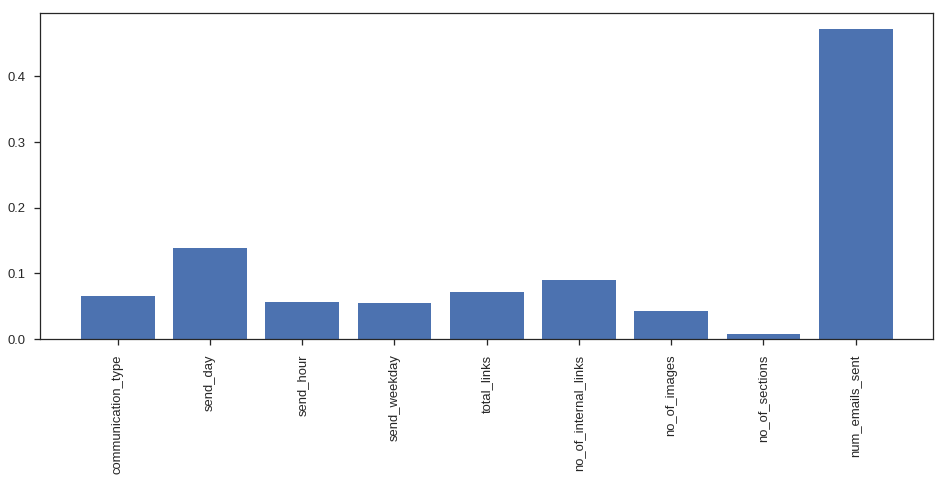

In [9]:
plt.figure(figsize=(16, 6))
plt.bar(np.arange(len(FEATURES)), m.feature_importances_)
plt.xticks(np.arange(len(FEATURES)), FEATURES, rotation=90);

## Full Training

In [8]:
%%time

m = RandomForestClassifier(n_estimators=20, max_depth=13, min_samples_leaf=3, random_state=SEED, n_jobs=3)
m.fit(X_trn, y_trn)
preds = m.predict_proba(X_val)[:, 1]

CPU times: user 1min 6s, sys: 204 ms, total: 1min 6s
Wall time: 23.8 s


## Submissions PB Leaderboard 0.5445650463

In [9]:
sub = pd.read_csv('../data/raw/sample_submission_4fcZwvQ.csv')
sub.loc[:, 'is_click'] = preds
sub.to_csv('../submissions/submission8.csv', index=False)